<a href="https://colab.research.google.com/github/bathaee/tensorflow-deep-learning/blob/main/Marzieh_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

from matplotlib import pyplot as plt

In [ ]:
import numpy as np
from keras.datasets.mnist import load_data
from matplotlib import pyplot as plt

(trainx,trainy), (testx,testy) = load_data()

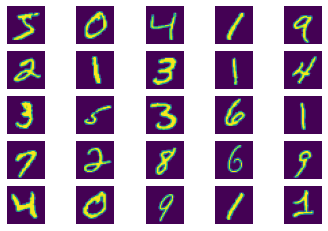

In [ ]:
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.axis('off')
  plt.imshow(trainx[i])
plt.show() 

In [ ]:
trainx.shape

(60000, 28, 28)

In [ ]:
# Function related to the Discriminator's network
def define_discriminator(in_shape=(28,28)):
  model = Sequential()
  model.add(Flatten(input_shape=in_shape))
  model.add(Dense(128,activation=LeakyReLU(alpha=0.2)))
  model.add(Dense(128,activation=LeakyReLU(alpha=0.2)))
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

#2. Compile the model for discriminator
  model.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(learning_rate=0.0002,beta_1=0.5), 
                metrics=['accuracy'])
  return model
D =  define_discriminator(in_shape=(28,28))
print(D.summary())  

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               100480    
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 117,121
Trainable params: 117,121
Non-trainable params: 0
_________________________________________________________________
None


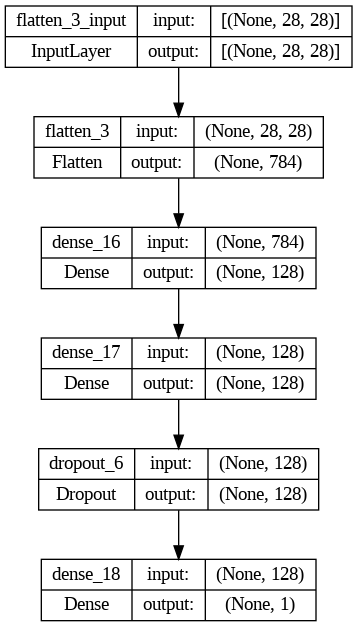

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model=D, show_shapes=True)

In [ ]:
# Function related to the Generator's network
def define_generator(latent_dim):
  n_nodes = 7*7*128
  model = Sequential()
  model.add(Dense(n_nodes,input_dim=latent_dim,activation=LeakyReLU(alpha=0.2)))
  model.add(Dense(128,activation=LeakyReLU(alpha=0.2)))
  model.add(Dense(128,activation=LeakyReLU(alpha=0.2)))
  model.add(Dense(28*28,activation='tanh'))
  model.add(Reshape((28,28)))
  return model
G =  define_generator(100)
print(G.summary())    

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 6272)              633472    
                                                                 
 dense_30 (Dense)            (None, 128)               802944    
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dense_32 (Dense)            (None, 784)               101136    
                                                                 
 reshape_4 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 1,554,064
Trainable params: 1,554,064
Non-trainable params: 0
_________________________________________________________________
None


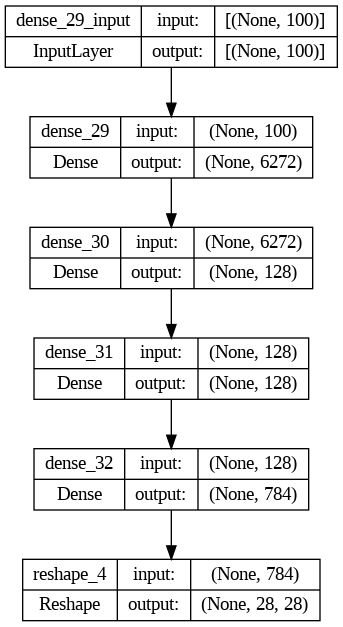

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model=G, show_shapes=True)

In [ ]:
# GAN-Combined 
# Define the combined generator and discriminator model, for updating the generator 
# Discriminator is trained separately so here only generator will be trained by keeping discriminator constant.

def define_gan(generator,discriminator):
  discriminator.trainable = False #discriminator is trained separately.
  # connect generator and discriminator
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  #compile model
  model.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(learning_rate=0.0002,beta_1=0.5), 
                metrics=['accuracy'])
  return model
GAN =   define_gan(G,D)
print(GAN.summary())  

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 28, 28)            1554064   
                                                                 
 sequential_10 (Sequential)  (None, 1)                 117121    
                                                                 
Total params: 1,671,185
Trainable params: 1,554,064
Non-trainable params: 117,121
_________________________________________________________________
None


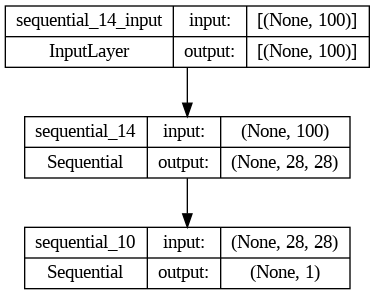

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model=GAN, show_shapes=True)

In [ ]:
def load_real_samples():
  (trainx, _),(_,_) = load_data()
  x = trainx.astype('float32')
  x = (x-127.5)/127.5 #scale -1 to 1
  return x
# real samples
def generate_real_samples(dataset,n_samples):
  ix = randint(0,dataset.shape[0],n_samples)
  x=dataset[ix]
  y=ones(n_samples)#label=1 indicating they are real
  return x,y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim,n_samples):
  x_input = randn(latent_dim*n_samples) #generate points in the latent space
  x_input = x_input.reshape(n_samples,latent_dim) 
  return x_input 

# fake samples  
def generate_fake_samples(generator,latent_dim,n_samples):
  x_input = generate_latent_points(latent_dim,n_samples)
  x = generator.predict(x_input)
  y= zeros(n_samples)# label = 0 indicating they are fake
  return x, y

In [ ]:
x1 = load_real_samples()
datasets = load_real_samples()
x2 = generate_real_samples(datasets,2)
x3 = generate_latent_points(100,2)

x1.shape,x3.shape,x2[0].shape

((60000, 28, 28), (2, 100), (2, 28, 28))

In [ ]:
datasets.shape

(60000, 28, 28)

In [ ]:
# The GAN training process-training code
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs,n_batch=128):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  #The discriminator model is updated for a half batch of real samples and a half batch of facke samples, combined a single batch.
  for i in range(n_epochs): # Enumerate epochs
      for j in range(bat_per_epo):# Enumerate batches
        x_real,y_real = generate_real_samples(dataset,half_batch) #Get some real images
        d_loss_real, _= d_model.train_on_batch(x_real,y_real) # update D weights on real images
        x_fake, y_fake = generate_fake_samples(g_model,latent_dim,half_batch) # Get fake images
        d_loss_fake, _ = d_model.train_on_batch(x_fake,y_fake) # update D weights on fake images

        x_gan = generate_latent_points(latent_dim,n_batch) #input for the generator
        y_gan = np.ones(n_batch,) #Label generated images as true to trick the discriminator

        g_loss = gan_model.train_on_batch(x_gan,y_gan) # train the generator with
        #print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
  g_model.save('mnist_generator_2epochs.h5')

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator,discriminator)
dataset = load_real_samples()

In [ ]:
#Train GAN
train(generator, discriminator, gan_model , dataset, latent_dim , n_epochs=2, n_batch=128)

2/2 [==============================] - 0s 12ms/step


In [ ]:
# Now, let us load the generator model and generate images

from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :])
	plt.show()


In [ ]:

# load model
model = load_model('mnist_generator_2epochs.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)

1/1 [==============================] - 0s 144ms/step


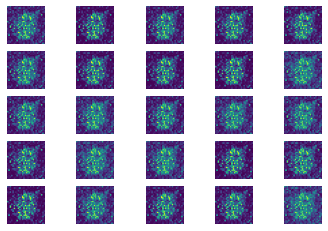

In [ ]:
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck